# Project: NLP-based Text Similarity Detection

## Project Overview
This project aims to develop an NLP-based text similarity system that can automatically identify duplicate or highly similar documents 
## Methodology
1. **Data Collection**: Load dataset from Hugging Face.
2. **Preprocessing**: Tokenization, stopword removal, lemmatization.
3. **Feature Extraction**: TF-IDF vectorization and Cosine Similarity computation.
4. **Model Training**: Logistic Regression based on similarity scores.
5. **Evaluation**: Accuracy, Precision, Recall, F1-score, and Confusion Matrix.

In [1]:
!pip install pandas numpy scikit-learn nltk datasets matplotlib seaborn hf_xet huggingface_hub[hf_xet]

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import string


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

c:\Users\samri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\samri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\samri\AppData\Roaming\nltk_d

True

## 2. Load Dataset
We will use the [`pszemraj/synthetic-text-similarity`](https://huggingface.co/datasets/pszemraj/synthetic-text-similarity) dataset.

In [ ]:
try:
    dataset = load_dataset("pszemraj/synthetic-text-similarity")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
df = pd.DataFrame(dataset['train'])

# Using 10,000 samples to avoid memory error
df = df.sample(n=10000, random_state=42)
print(f"Dataset sampled to {len(df)} rows.")

print(df.head())
print(df.columns)

Dataset loaded successfully.
Dataset sampled to 10000 rows.
                                                   text1  \
75721  LOS ANGELES, California (CNN) -- Sens. Hillary...   
80184  Then, these are beside a real-time rely of onl...   
19864  # protected property FormState::\$validation_c...   
76699  [GOAL]\nα : Type u_1\nV : Type u_2\nP : Type u...   
92991   3.1 The History of Birth Control in the Unite...   

                                                   text2     label  
75721  [dart:developer](../dart-developer/dart-develo...  0.330286  
80184  LIC Cards is a wholly-owned subsidiary of Life...  0.532725  
19864  Hey guys over here in Ireland we havnt heard a...  0.328603  
76699  OPINION\nCOATS, Judge.\nMarshall Moss was conv...  0.306061  
92991  REALITY VERSUS AUTHENTICITY: MAPPING THE SCAFF...  0.535884  
Index(['text1', 'text2', 'label'], dtype='str')


## 3. Data Preprocessing
Cleaning the text data by tokenizing, removing stopwords, and lemmatizing.

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)


df['processed_1'] = df['text1'].apply(preprocess_text)
df['processed_2'] = df['text2'].apply(preprocess_text)

print(df[['processed_1', 'processed_2']].head())

                                             processed_1  \
75721  los angeles california cnn sen hillary clinton...   
80184  beside realtime rely online chatter online fre...   
19864  protected property formstatevalidationcomplete...   
76699  goal α type u1 v type u2 p type u3 w type u4 q...   
92991  31 history birth control united state birth co...   

                                             processed_2  
75721  dartdeveloperdartdeveloperdartdeveloperlibrary...  
80184  lic card whollyowned subsidiary life insurance...  
19864  hey guy ireland havnt heard single thing news ...  
76699  opinion coat judge marshall moss convicted fol...  
92991  reality versus authenticity mapping scaffoldin...  


## 4. Feature Extraction
We will compute the TF-IDF vectors for the documents and then calculate the Cosine Similarity between pairs.

In [ ]:
# Use max_features to limit vocabulary size and avoid MemoryError
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit the vectorizer on all text data to ensure consistent vocabulary
all_text = pd.concat([df['processed_1'], df['processed_2']])
print(f"Fitting vectorizer on {len(all_text)} documents...")
tfidf_vectorizer.fit(all_text)

print("Transforming documents...")
tfidf_1 = tfidf_vectorizer.transform(df['processed_1'])
tfidf_2 = tfidf_vectorizer.transform(df['processed_2'])

# Cosine Similarity for each pair
# cosine_similarity returns a matrix, we need the diagonal elements (pair-wise)
# However, computing the full matrix for large datasets is memory intensive.
# We can compute row-wise dot product of normalized vectors.

from sklearn.metrics.pairwise import linear_kernel

cosine_scores = []
print("Computing cosine similarity...")
for i in range(tfidf_1.shape[0]):
    # Compute similarity between doc i in list 1 and doc i in list 2
    # Reshape to (1, -1) to pass to cosine_similarity
    similarity = cosine_similarity(tfidf_1[i], tfidf_2[i])[0][0]
    cosine_scores.append(similarity)

df['cosine_similarity'] = cosine_scores

print(df[['cosine_similarity', 'label']].head())

Fitting vectorizer on 20000 documents...
Transforming documents...
Computing cosine similarity...
       cosine_similarity     label
75721           0.004932  0.330286
80184           0.036098  0.532725
19864           0.000000  0.328603
76699           0.000643  0.306061
92991           0.065809  0.535884


## 5. Model Training and Evaluation
We will use the Cosine Similarity score as a feature to train a Logistic Regression classifier.

Labels appear to be continuous. Binarizing with threshold 0.5 to convert to classification task...
Target Label Distribution:
label
1    6278
0    3722
Name: count, dtype: int64
Accuracy: 0.842
Precision: 0.850081149289404
Recall: 0.842
F1-score: 0.8438257082438237

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.80       733
           1       0.91      0.84      0.87      1267

    accuracy                           0.84      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.85      0.84      0.84      2000



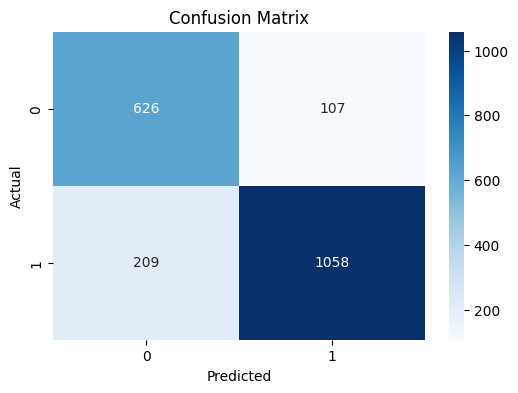

In [6]:
X = df[['cosine_similarity']]
y = df['label']

# Check if labels are continuous/float and convert to binary for classification
# If labels are similarity scores (0.0 to 1.0), we threshold at 0.5
if y.dtype == 'float' or y.dtype == 'float64' or y.dtype == 'float32':
    print("Labels appear to be continuous. Binarizing with threshold 0.5 to convert to classification task...")
    y = (y > 0.5).astype(int)

print("Target Label Distribution:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusion
The Logistic Regression model was trained using Cosine Similarity scores derived from TF-IDF vectors of the document pairs. The evaluation metrics above demonstrate the performance of the system.